In [1]:
import axs
import numpy as np

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as pyspark_types
import numpy as np

from functools import partial

import tqdm

In [2]:
%matplotlib notebook

# Setup spark

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            #.config("spark.master", "local[32]") # yolo mode
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/kyboone/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

Hovering over "Spark UI" above gives you the port number of the Spark web dashboard.  Epyc doesn't have that port open, though, so we use an SSH tunnel to forward the ports.  I like to put the following function into my `.bashrc` o my local machine:


```
function spark_tunnel()
{
        # this function takes one argument: the epyc port to tunnel
        # the ordering is backwards (requiring a manual refresh) because
        # I want to be able to manually kill the ssh tunnel
        open http://localhost:${1}/
        ssh -N -L ${1}:127.0.0.1:${1} username@epyc.astro.washington.edu
}
```

What tables does AXS know about?

In [5]:
#catalog.list_table_names()

# Load ZTF data

In [6]:
ztf = catalog.load('ztf_oct19')

# Plotting

In [7]:
band_colors = {
    'g': 'tab:green',
    'r': 'tab:red',
    'i': 'tab:purple'
    
}

def plot_lightcurve(row, parsed=True):
    plt.figure(figsize=(8, 6), dpi=100)

    for band in ['g', 'r', 'i']:
        if parsed:
            mjd, mag, magerr = parse_observations(
                row[f'mjd_{band}'],
                row[f'mag_{band}'],
                row[f'magerr_{band}'],
                row[f'xpos_{band}'],
                row[f'ypos_{band}'],
                row[f'catflags_{band}'],
            )
        else:
            mask = (
                (np.array(row[f'catflags_{band}']) == 0.)
            )

            mjd = np.array(row[f'mjd_{band}'])[mask]
            mag = np.array(row[f'mag_{band}'])[mask]
            magerr = np.array(row[f'magerr_{band}'])[mask]

        plt.errorbar(mjd, mag, magerr, fmt='o', c=band_colors[band], label=f'ZTF-{band}')

    plt.xlabel('MJD')
    if parsed:
        plt.ylabel('Magnitude + offset')
    else:
        plt.ylabel('Magnitude')
    plt.legend()
    plt.title('objid %d' % row['objid'])
    plt.gca().invert_yaxis()

# Cython setup

In [8]:
def setup_pyximport():
    import pyximport
    pyximport.install(reload_support=True, setup_args={'include_dirs': np.get_include()})

class cython_function():
    def __init__(self, module, name):
        self.module = module
        self.name = name
        self.function = None
        
        self.load_function()
        
    def load_function(self):
        setup_pyximport()
        self.function = getattr(__import__(self.module), self.name)
        
    def __call__(self, *args, **kwargs):
        if self.function is None:
            self.load_function()

        return self.function(*args, **kwargs)
    
    def __getstate__(self):
        # Don't return the module so that each node has to recompile it itself.
        state = self.__dict__.copy()
        state['function'] = None
        return state

In [9]:
group_observations = cython_function('dipper', 'group_observations')
#detect_dippers = cython_function('dipper', 'detect_dippers')

In [10]:
# Call this function to recompile the cython code whenever needed.
def reload_dipper():
    import sys
    setup_pyximport()

    try:
        del sys.modules['dipper']
    except KeyError:
        pass
    import dipper

    #detect_dippers.function = None
    group_observations.function = None

# Detect dippers

In [91]:
from scipy.ndimage import minimum_filter1d

def parse_observations(mjd, mag, magerr, xpos, ypos, catflags):
    """Parse a list of observations and convert them to a set of
    differences in magnitudes with uncertainties.
    
    Bad observations will be removed.
    
    Returns
    -------
    parsed_mjd : numpy.array
        Sorted array of parsed MJDs.
    parsed_mag : numpy.array
        Corresponding magnitude differences relative to the median flux
    parsed_magerr : numpy.array
        Magnitude uncertainties, including contributions from the intrinsic dispersion
        if applicable.
    """
    if len(mjd) == 0:
        return [], [], []

    mjd = np.array(mjd)
    order = np.argsort(mjd)

    # Convert everything to numpy arrays and sort them by MJD
    sort_mjd = mjd[order]
    sort_mag = np.array(mag)[order]
    sort_magerr = np.array(magerr)[order]
    sort_xpos = np.array(xpos)[order]
    sort_ypos = np.array(ypos)[order]
    sort_catflags = np.array(catflags)[order]

    # Mask out bad or repeated observations.
    pad_width = 20
    x_border = 3072
    y_border = 3080

    mask = (
        (np.abs(sort_mjd - np.roll(sort_mjd, 1)) > 1e-5)
        & (sort_xpos > pad_width)
        & (sort_xpos < x_border - pad_width)
        & (sort_ypos > pad_width)
        & (sort_ypos < y_border - pad_width)
        & (sort_catflags == 0)
        
        # In the oct19 data, some observations have a magerr of 0 and aren't flagged.
        # This causes a world of problems, so throw them out.
        & (sort_magerr > 0)
        
        # In the oct19 data, a lot of dippers are the result of bad columns...
        # Unfortunately, in this version of the ZTF data we don't know which amplifier
        # everything came from. To get a reasonably clean sample (with some unnecessary
        # attrition), we cut any observations that are in the "bad" x ranges.
        & ((sort_xpos < 24) | (sort_xpos > 31))
        & ((sort_xpos < 95) | (sort_xpos > 106))
        & ((sort_xpos < 328) | (sort_xpos > 333))
        & ((sort_xpos < 1169) | (sort_xpos > 1177))
        & ((sort_xpos < 1249) | (sort_xpos > 1257))
        & ((sort_xpos < 1339) | (sort_xpos > 1349))
        & ((sort_xpos < 2076) | (sort_xpos > 2100))
        & ((sort_xpos < 2521) | (sort_xpos > 2537))
        & ((sort_xpos < 2676) | (sort_xpos > 2682))
        & ((sort_xpos < 2888) | (sort_xpos > 2895))
    )

    if np.sum(mask) < 10:
        # Require at least 10 observations to have reasonable statistics.
        return [], [], []
        
    mask_mjd = sort_mjd[mask]
    mask_mag = sort_mag[mask]
    mask_magerr = sort_magerr[mask]

    # Calculate statistics on the light curve. To avoid being affected by periods with
    # many rapid observations, we only consider observations that are separated by
    # a given amount of time.
    min_delta_time = 0.5 # days
    min_time_mask = (np.abs(mask_mjd - np.roll(mask_mjd, 1)) > min_delta_time)
    
    use_mag = mask_mag[min_time_mask]
    
    # Subtract the reference flux from the observations.
    base_mag = np.median(use_mag)
    parsed_mag = mask_mag - base_mag
    
    # Get an estimate of the standard deviation of the core of the observations
    # from the NMAD.
    #core_std = 1.4826 * np.nanmedian(np.abs(use_mag - np.nanmedian(use_mag)))
    
    # Estimate the uncertainty for each observation. For well-measured observations,
    # use the core standard deviation. For poorly measured ones, use the measured
    # standard deviation. The core standard deviation should be very similar to the
    # measured ones for stable light curves, so we shouldn't be adding these in quadrature.
    # Instead, we take whichever value is larger.
    #parsed_magerr = mask_magerr.copy()
    #parsed_magerr[parsed_magerr < core_std] = core_std
    
    return mask_mjd, parsed_mag, mask_magerr

def detect_dippers(mjd_g, mag_g, magerr_g, xpos_g, ypos_g, catflags_g,
                   mjd_r, mag_r, magerr_r, xpos_r, ypos_r, catflags_r,
                   max_dt=2., min_nobs=3, min_dip_time=2., threshold=3.):
    
    parsed_mjd_g, parsed_mag_g, parsed_magerr_g = parse_observations(
        mjd_g, mag_g, magerr_g, xpos_g, ypos_g, catflags_g
    )
    parsed_mjd_r, parsed_mag_r, parsed_magerr_r = parse_observations(
        mjd_r, mag_r, magerr_r, xpos_r, ypos_r, catflags_r
    )
    
    mjd = np.hstack([parsed_mjd_g, parsed_mjd_r])
    order = np.argsort(mjd)
    mjd = mjd[order]
    mag = np.hstack([parsed_mag_g, parsed_mag_r])[order]
    magerr = np.hstack([parsed_magerr_g, parsed_magerr_r])[order]
    
    significance = mag / magerr
    
    # Measure dips. The dip is defined as all observations with decrease
    # in flux with a significance greater than the given threshold. We require
    # that observations of the dip have a cadence of at most max_dt, and that
    # there are observations with no significance on either side of the dip.
    # Note that the filters have been merged together (after subtracting the
    # reference flux), so we are looking for relatively gray dips.    
    
    dip_start_mjd = None
    
    best_intmag = -1.
    best_start_mjd = float('nan')
    best_end_mjd = float('nan')
    best_nobs = 0
    best_complexity = float('nan')

    num_dips = 0

    for idx in range(1, len(mjd)):        
        if mjd[idx] - mjd[idx-1] > max_dt:
            # We have a gap in observations larger than our desired threshold.
            # The previous dip (if there was one) can't be used.
            
            # Reset
            dip_start_mjd = None
        elif significance[idx] >= threshold:
            # Found a significant observation. Increase the current nobs.

            if dip_start_mjd is None:
                if significance[idx-1] >= threshold:
                    # Continuation of a dip that we didn't identify the start of.
                    # Ignore it.
                    pass
                else:
                    # Found the start of a dip. Start recording it.
                    dip_start_mjd = mjd[idx]

                    dip_intmag = 0.
                    dip_nobs = 1
                    dip_max_mag = mag[idx]
                    dip_sum_deltas = mag[idx] - magerr[idx]
            else:
                # Inside of a dip.
                dip_nobs += 1
                
                # Integrate the magnitude using the trapezoid rule.
                mean_mag = (mag[idx] + mag[idx-1]) / 2.
                dt = mjd[idx] - mjd[idx-1]
                dip_intmag += dt * mean_mag
                
                if mag[idx] > dip_max_mag:
                    dip_max_mag = mag[idx]
                
                dip_sum_deltas += np.abs(mag[idx] - mag[idx-1]) - magerr[idx]
        elif dip_start_mjd is not None:
            # We found the end of a dip. Record it if it is the best one.
            dip_sum_deltas += mag[idx-1] - magerr[idx]
            
            dip_complexity = dip_sum_deltas / dip_max_mag / 2.
            
            if (dip_intmag > best_intmag
                    and dip_nobs >= min_nobs
                    and (mjd[idx-1] - dip_start_mjd) > min_dip_time):
                best_intmag = dip_intmag
                best_start_mjd = dip_start_mjd
                best_end_mjd = mjd[idx-1]
                best_nobs = dip_nobs
                best_complexity = dip_complexity

            # Reset
            dip_start_mjd = None
    
        # Count the total number of dips. We don't care if we capture the edges properly
        # for this, we just care about finding every time that we transition above the
        # threshold. This is helpful for vetoing highly variable objects.
        if significance[idx] > threshold and significance[idx - 1] < threshold:
            num_dips += 1
            
    # Get a measure of the significance of the dip by comparing the integrated size
    # of the dip to the typical variation scale of the light curve.
    min_delta_time = 0.5 # days

    mask = (
        ((mjd < best_start_mjd - 5) | (mjd > best_end_mjd + 5))
        & (np.abs(mjd - np.roll(mjd, 1)) > min_delta_time)
    )

    if np.sum(mask) < 5:
        dip_significance = 0.
    else:
        mask_std = np.std(mag[mask])
        dip_significance = best_intmag / mask_std
                        
    return (
        float(best_intmag),
        float(best_start_mjd),
        float(best_end_mjd),
        int(best_nobs),
        float(best_complexity),
        float(dip_significance),
        int(num_dips)
    )

# Wrappers

In [92]:
def detect_dippers_row(row, *args, **kwargs):
    result = detect_dippers(
        row['mjd_g'],
        row['mag_g'],
        row['magerr_g'],
        row['xpos_g'],
        row['ypos_g'],
        row['catflags_g'],
        row['mjd_r'],
        row['mag_r'],
        row['magerr_r'],
        row['xpos_r'],
        row['ypos_r'],
        row['catflags_r'],
        *args,
        **kwargs
    )
    
    return {
        'intmag': result[0],
        'start_mjd': result[1],
        'end_mjd': result[2],
        'nobs': result[3],
        'complexity': result[4],
        'significance': result[5],
        'num_dips': result[6],
    }

In [93]:
# Create a UDF for spark

schema = pyspark_types.StructType([
    pyspark_types.StructField("intmag", pyspark_types.FloatType(), False),
    pyspark_types.StructField("start_mjd", pyspark_types.FloatType(), True),
    pyspark_types.StructField("end_mjd", pyspark_types.FloatType(), True),
    pyspark_types.StructField("nobs", pyspark_types.IntegerType(), True),
    pyspark_types.StructField("complexity", pyspark_types.FloatType(), True),
    pyspark_types.StructField("significance", pyspark_types.FloatType(), False),
    pyspark_types.StructField("num_dips", pyspark_types.IntegerType(), False),
])

detect_dippers_udf = sparkfunc.udf(detect_dippers, schema)

# Run the spark query

## Run and save the query

In [26]:
%%time

# Run on spark
res = (
    ztf
    #.region(ra1=270, ra2=310, dec1=-10, dec2=40)
    #.region(ra1=295, ra2=296, dec1=20, dec2=21)
    .exclude_duplicates()
    .where(
        (sparkfunc.col("nobs_g") >= 10)
        | (sparkfunc.col("nobs_r") >= 10)
        | (sparkfunc.col("nobs_i") >= 10)
    )
    .select(
        '*',
        detect_dippers_udf(ztf['mjd_g'], ztf['mag_g'], ztf['magerr_g'], ztf['xpos_g'], ztf['ypos_g'], ztf['catflags_g']).alias('score_g'),
        detect_dippers_udf(ztf['mjd_r'], ztf['mag_r'], ztf['magerr_r'], ztf['xpos_r'], ztf['ypos_r'], ztf['catflags_r']).alias('score_r'),
        detect_dippers_udf(ztf['mjd_i'], ztf['mag_i'], ztf['magerr_i'], ztf['xpos_i'], ztf['ypos_i'], ztf['catflags_i']).alias('score_i')
    )
    .where(
        (sparkfunc.col("score_g") > 4.)
        | (sparkfunc.col("score_r") > 4.)
        | (sparkfunc.col("score_i") > 4.)
    )
    #.write.parquet('./query_test_22.parquet')
    .write.parquet('./query_full_3.parquet')
)

AnalysisException: "cannot resolve '(`score_g` > 4.0D)' due to data type mismatch: differing types in '(`score_g` > 4.0D)' (struct<intmag:float,start_mjd:float,end_mjd:float,nobs:int,complexity:float,num_dips:int> and double).;;\n'Filter (((score_g#25259 > 4.0) || (score_r#25261 > 4.0)) || (score_i#25263 > 4.0))\n+- Project [objid#0L, ra#1, dec#2, mean_mag_g#3, mean_mag_r#4, mean_mag_i#5, _debug_first_ra#6, _debug_first_dec#7, ps1_gMeanPSFMag#8, ps1_rMeanPSFMag#9, ps1_iMeanPSFMag#10, mjd_g#11, mag_g#12, magerr_g#13, psfflux_g#14, psffluxerr_g#15, catflags_g#16, expid_g#17, xpos_g#18, ypos_g#19, nobs_g#20L, mjd_r#21, mag_r#22, magerr_r#23, ... 22 more fields]\n   +- Filter (((nobs_g#20L >= cast(10 as bigint)) || (nobs_r#30L >= cast(10 as bigint))) || (nobs_i#40L >= cast(10 as bigint)))\n      +- Filter (dup#42 = 0)\n         +- SubqueryAlias `default`.`ztf_oct19`\n            +- Relation[objid#0L,ra#1,dec#2,mean_mag_g#3,mean_mag_r#4,mean_mag_i#5,_debug_first_ra#6,_debug_first_dec#7,ps1_gMeanPSFMag#8,ps1_rMeanPSFMag#9,ps1_iMeanPSFMag#10,mjd_g#11,mag_g#12,magerr_g#13,psfflux_g#14,psffluxerr_g#15,catflags_g#16,expid_g#17,xpos_g#18,ypos_g#19,nobs_g#20L,mjd_r#21,mag_r#22,magerr_r#23,... 19 more fields] parquet\n"

## Convert to an axs table

In [14]:
wtf = spark_session.read.parquet('./query_full_3.parquet')

In [15]:
catalog.save_axs_table(wtf, 'wtf_full_oct19_3', repartition=True)

## Load the saved axs table

In [94]:
wtf = catalog.load('wtf_full_oct19_3')

In [95]:
wtf.count()

159994

In [96]:
# Redo the scores

rescored_wtf = (
    wtf.select(
        '*',
        detect_dippers_udf(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r']
        ).alias('dipper'),
    )
    #.where(
    #    (sparkfunc.col("dipper.num_dips") < 5)
    #    & (sparkfunc.col("dipper.complexity") < 4.)
    #)
)

In [97]:
%%time

# Get the best entries
res = rescored_wtf.sort(rescored_wtf['dipper.significance'].desc()).head(1000)

CPU times: user 1.26 s, sys: 285 ms, total: 1.54 s
Wall time: 1min 36s


In [98]:
def print_links(row):
    print("http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%.6f%+.6f&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=" % (row['ra'], row['dec']))
    print("RA+Dec: %.6f%+.6f" % (row['ra'], row['dec']))
    print("RA:     %.6f" % row['ra'])
    print("Dec:    %.6f" % row['dec'])
    
def show_lightcurve(row, zoom=False):
    print_links(row)
    
    print("")
    print("Dip details:")
    for key, value in row['dipper'].asDict().items():
        print(f"{key:11s}: {value}")

    plot_lightcurve(row)
    
    start_mjd = row['dipper']['start_mjd']
    end_mjd = row['dipper']['end_mjd']
    
    plt.axvline(start_mjd, c='k', ls='--')
    plt.axvline(end_mjd, c='k', ls='--')
    
    if zoom:
        plt.xlim(start_mjd - 10, end_mjd + 10)

In [100]:
%matplotlib inline

from ipywidgets import interact, IntSlider

def interact_lightcurve(idx, zoom=False):
    show_lightcurve(res[idx], zoom=zoom)

interact(interact_lightcurve, idx=IntSlider(0, 0, len(res) - 1))

interactive(children=(IntSlider(value=0, description='idx', max=999), Checkbox(value=False, description='zoom'), Output()), _dom_classes=('widget-interact',))

<function __main__.interact_lightcurve>

In [53]:
# Update the scores

# reload_dipper()

num_sequential = 5

updated_detect_dippers_udf = sparkfunc.udf(
    partial(detect_dippers, num_sequential=num_sequential),
    returnType=pyspark_types.FloatType()
)

rescored_wtf = wtf.select(
    '*',
    updated_detect_dippers_udf(wtf['mjd_g'], wtf['mag_g'], wtf['magerr_g'], wtf['xpos_g'], wtf['ypos_g'], wtf['catflags_g']).alias('new_score_g'),
    updated_detect_dippers_udf(wtf['mjd_r'], wtf['mag_r'], wtf['magerr_r'], wtf['xpos_r'], wtf['ypos_r'], wtf['catflags_r']).alias('new_score_r'),
    updated_detect_dippers_udf(wtf['mjd_i'], wtf['mag_i'], wtf['magerr_i'], wtf['xpos_i'], wtf['ypos_i'], wtf['catflags_i']).alias('new_score_i')
)

In [55]:
%%time

# Get the best entries
res_g = rescored_wtf.sort(rescored_wtf.new_score_g.desc()).head(1000)
res_r = rescored_wtf.sort(rescored_wtf.new_score_r.desc()).head(1000)

CPU times: user 3.38 s, sys: 1.13 s, total: 4.52 s
Wall time: 1min 52s


# Joining

In [12]:
gaia = catalog.load('gaia_dr2_1am_dup')

In [13]:
wtf_df = wtf.crossmatch(gaia.select('ra', 'dec', 'zone', 'dup', 'parallax', 'parallax_over_error', 'phot_g_mean_mag',
                                'bp_rp')).toPandas()

In [17]:
new_scores = []
for idx, row in tqdm.tqdm(wtf_df.iterrows()):
    new_scores.append(detect_dippers_row(row))

wtf_df['new_score'] = new_scores

41942it [00:56, 748.45it/s]


/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


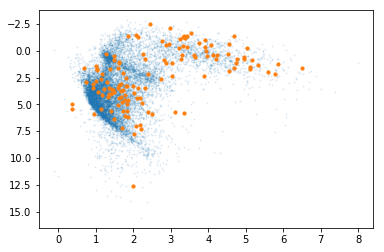

In [36]:
plt.figure()
abs_mag = wtf_df['phot_g_mean_mag'] - 5 * np.log10(1000 / wtf_df['parallax']) + 5

cut = (wtf_df['parallax_over_error'] > 5)
plt.scatter(wtf_df['bp_rp'][cut], abs_mag[cut], s=1, alpha=0.1)

cut = (wtf_df['parallax_over_error'] > 5) & (wtf_df['new_score'] > 2.5)
plt.scatter(wtf_df['bp_rp'][cut], abs_mag[cut], s=10)


plt.gca().invert_yaxis()

In [40]:
def print_links(row):
    print("http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%.6f%+.6f&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=" % (row['ra'], row['dec']))
    print("RA+Dec: %.6f%+.6f" % (row['ra'], row['dec']))
    print("RA:     %.6f" % row['ra'])
    print("Dec:    %.6f" % row['dec'])

def show_lightcurve(idx):
    row = wtf_df.iloc[idx]  
    #print_links(row)    
    plot_lightcurve(row)
    plt.title(idx)

    print("Score:  %.3f" % detect_dippers_row(row))

In [41]:
a = np.where(cut & (df['bp_rp'] > 0.5) & (df['bp_rp'] < 2) & (abs_mag < 1000) & (abs_mag > 5.))

Score:  2.566
Score:  2.795
Score:  2.650
Score:  2.909
Score:  2.530
Score:  2.687
Score:  2.845
Score:  2.584
Score:  2.648
Score:  3.264
Score:  3.082


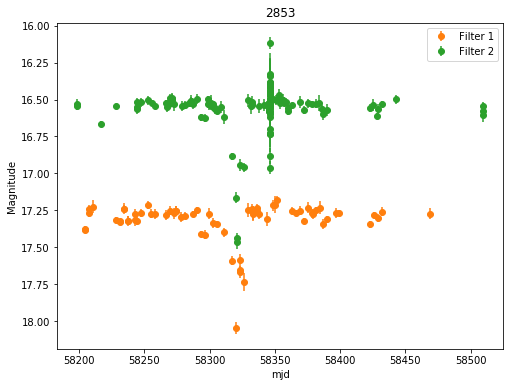

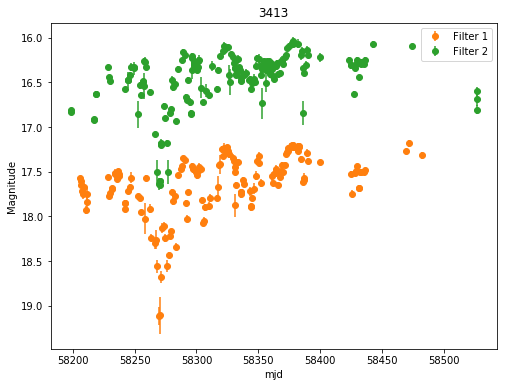

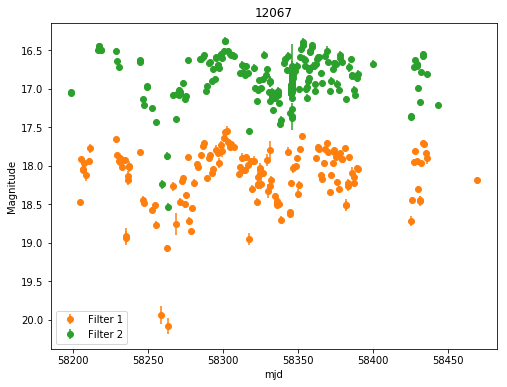

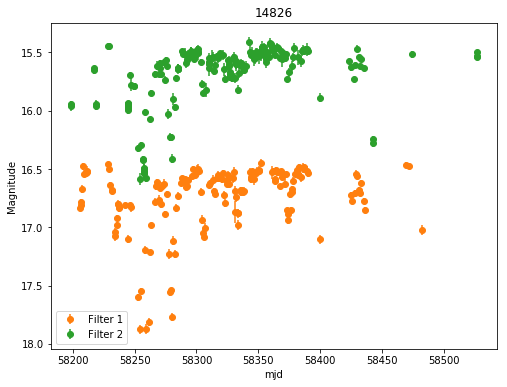

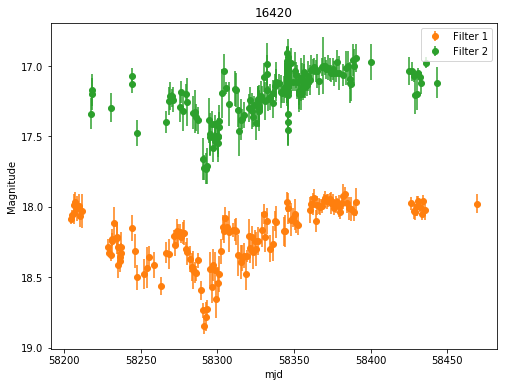

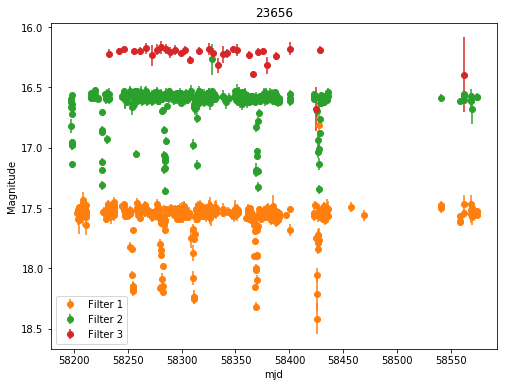

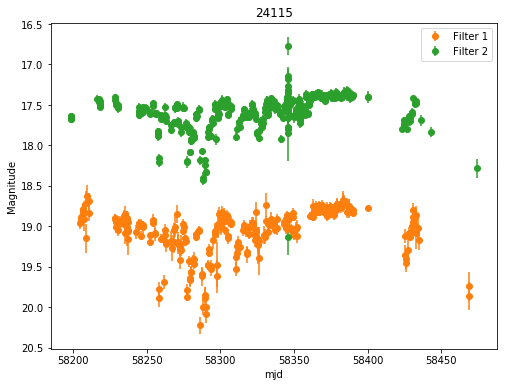

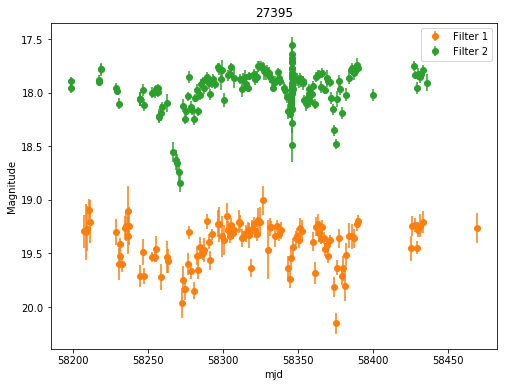

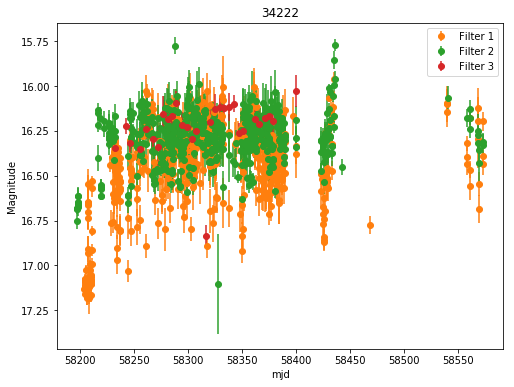

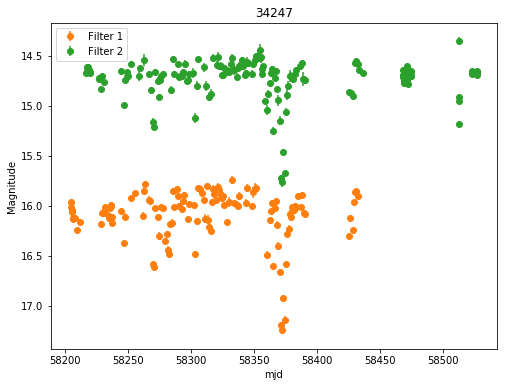

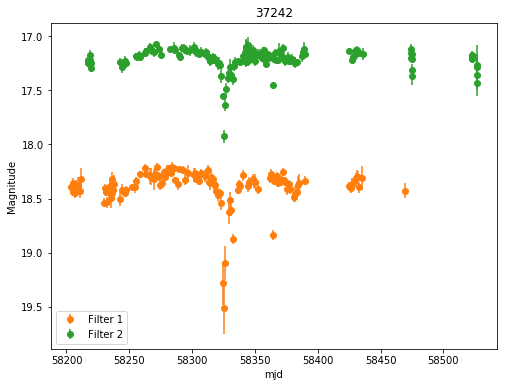

In [42]:
for i in a[0]:
    show_lightcurve(i)